In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir,path
from sklearn.metrics import confusion_matrix,f1_score, recall_score,classification_report,ConfusionMatrixDisplay
import cv2
import imutils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import image_dataset_from_directory
import shutil
from os import listdir, path
import pydicom
import seaborn as sns


In [ ]:

def load_scans(dcm_path):

    files = [file for file in listdir(dcm_path) if file.endswith(".dcm")]
    scans = [pydicom.dcmread(path.join(dcm_path, file), force=True) for file in files]
    return files, scans

def save_scans(files, src_dir, dest_dir):
    
    os.makedirs(dest_dir)
    for file in files:
        shutil.copy(path.join(src_dir, file), dest_dir)

# Burada tümor ve aneurysm klasörlerin içindeki dosya türleri karışık verilmişti (dcm ve jpg karışık). 
# Ben bunları iki farklı dosya açarak tümördeki "dcm" uzantılı olanlarını ayrı klasöre, aneurysm kalsöründeki "dcm" uzantılı olanları ayrı klasöre aktardım


In [6]:
aneurysm_files, aneurysm_scans = load_scans("./aneurysm")
save_scans(aneurysm_files, "./aneurysm", "./aneurysm_new")
#aneurysm için farklı klasöre atama yöntemi

In [7]:
tumor_files, tumor_scans = load_scans("./tumor")
save_scans(tumor_files, "./tumor", "./tumor_new")
#tumor için farklı klasöre atama yöntemi

In [ ]:
def process_images(scans):
    """Processes DICOM images.

    Args:
        scans: List of pydicom.Dataset objects.

    Returns:
        List of processed images as NumPy arrays.
    """
    processed_images = []
    for scan in scans:
        image_data = scan.pixel_array
        image_data = cv2.cvtColor((image_data / image_data.max() * 255).astype('uint8'), cv2.COLOR_GRAY2BGR)
        processed_images.append(image_data)
    return processed_images

processed_tumor_images = process_images(tumor_scans)
processed_aneurysm_images = process_images(aneurysm_scans) # her bir dcm uzantının matrislerini elde ediyor.

#Burada görüntülerin her birini matrise çevirdik

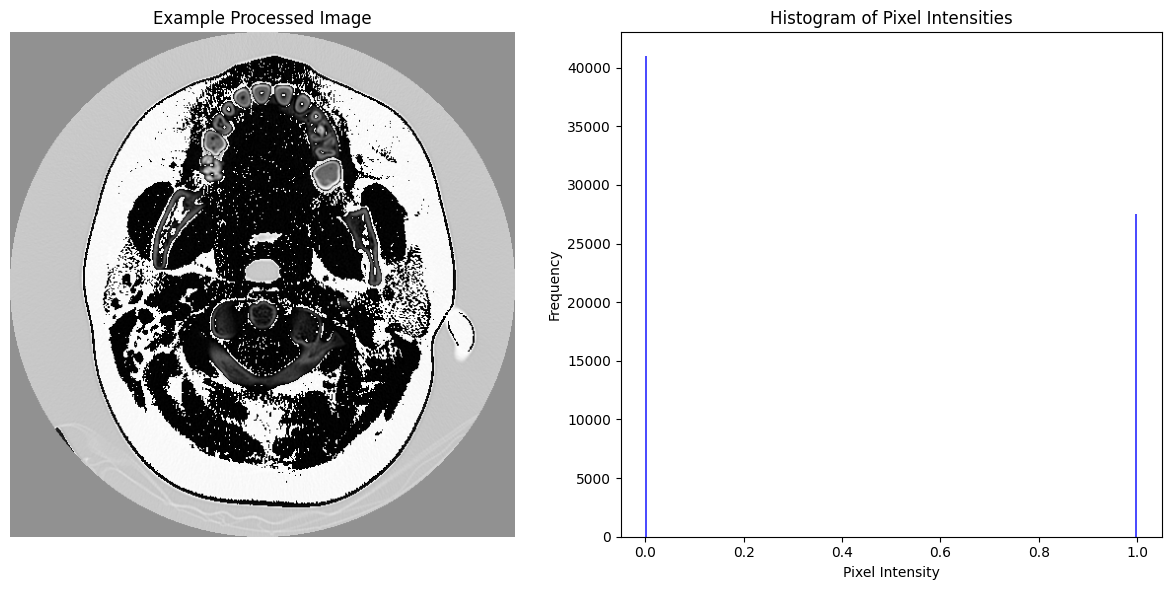

In [ ]:
example_image = processed_tumor_images[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Example Processed Image")
plt.imshow(example_image, cmap='gray')
plt.axis('off')
# Display the histogram
plt.subplot(1, 2, 2)
plt.title("Histogram of Pixel Intensities")
plt.hist(example_image.ravel(), bins=256, range=(0.0, 1.0), color='blue', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#Burada normalize adımı oluşturmadan önceki orjinal dcm uzantılı görsel.

In [10]:
processed_tumor_images[0]
#gördüğün gibi üsttekinin 1. görsel için matrisleri

array([[[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       [[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       [[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       ...,

       [[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       [[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]],

       [[145, 145, 145],
        [145, 145, 145],
        [145, 145, 145],
        ...,
        [145, 145, 145],
        [145, 145, 145],
        [145, 145, 145]]

In [ ]:
def normalize_and_resize(images, image_size):
    """Normalizes and resizes images.

    Args:
        images: List of images as NumPy arrays.
        image_size: Desired image size as a tuple (width, height).

    Returns:
        Array of normalized and resized images.
    """
    processed_images = []
    for image in images:
        resized_image = cv2.resize(image, dsize=image_size, interpolation=cv2.INTER_CUBIC)
        normalized_image = resized_image / 255.0
        processed_images.append(normalized_image)
    return np.array(processed_images) 
normalize_and_resize_tumor=normalize_and_resize(processed_tumor_images,(126,126))
normalize_and_resize_aneurysm=normalize_and_resize(processed_aneurysm_images,(126,126))
#burada normalize ve resize işlemi yaptık. 

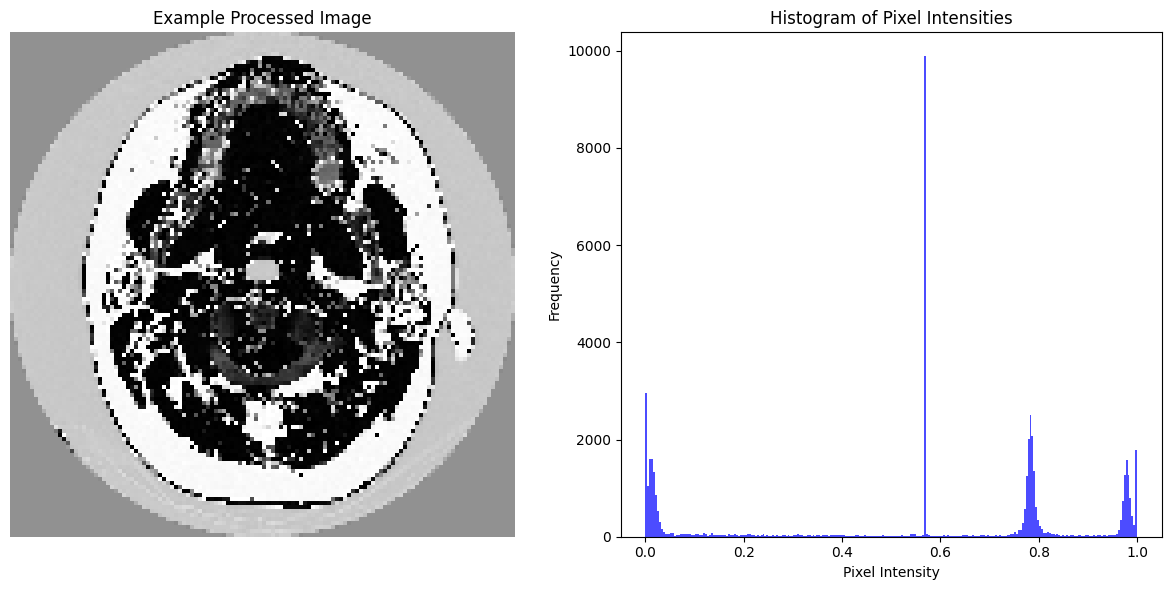

In [12]:
example_image = normalize_and_resize_tumor[0]

# Plot the example image and its histogram
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 1)
plt.title("Example Processed Image")
plt.imshow(example_image, cmap='gray')
plt.axis('off')

# Display the histogram
plt.subplot(1, 2, 2)
plt.title("Histogram of Pixel Intensities")
plt.hist(example_image.ravel(), bins=256, range=(0.0, 1.0), color='blue', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#Burada normalize adımı oluşturduktan sonraki dcm uzantılı görsel.
#Buna normalize olmadan önce ve normalize olduktan sonra diye ön işleme adımına eklenmesi gerekiyor.

In [ ]:
def normalize_resize_equalize(dcm_files, output_size):
    """Normalizes, resizes, and applies histogram equalization to DICOM images.

    Args:
        dcm_files: List of paths to DICOM files.
        output_size: Desired image size as a tuple (width, height).

    Returns:
        Array of processed images.
    """
    processed_images = []
    
    for dcm_file in dcm_files:
        # Read DICOM file
        dicom_data = pydicom.dcmread(dcm_file)
        pixel_array = dicom_data.pixel_array
        
        # Normalize pixel values to 0-255
        pixel_array = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255
        pixel_array = pixel_array.astype(np.uint8)
        
        # Apply histogram equalization
        equalized_image = cv2.equalizeHist(pixel_array)
        
        # Resize image
        resized_image = cv2.resize(equalized_image, dsize=output_size, interpolation=cv2.INTER_CUBIC)
        
        # Normalize resized image to 0-1
        normalized_image = resized_image / 255.0
        
        processed_images.append(normalized_image)
    
    return np.array(processed_images)

# Example usage
tumor_dcm_files = [os.path.join('./tumor', f) for f in os.listdir('./tumor') if f.endswith('.dcm')]
aneurysm_dcm_files = [os.path.join('./aneurysm', f) for f in os.listdir('./aneurysm') if f.endswith('.dcm')]

processed_tumor_images_fail = normalize_resize_equalize(tumor_dcm_files, (126, 126))
processed_aneurysm_images_fail = normalize_resize_equalize(aneurysm_dcm_files, (126, 126))


#Başarısız bir normalize adımıdır.

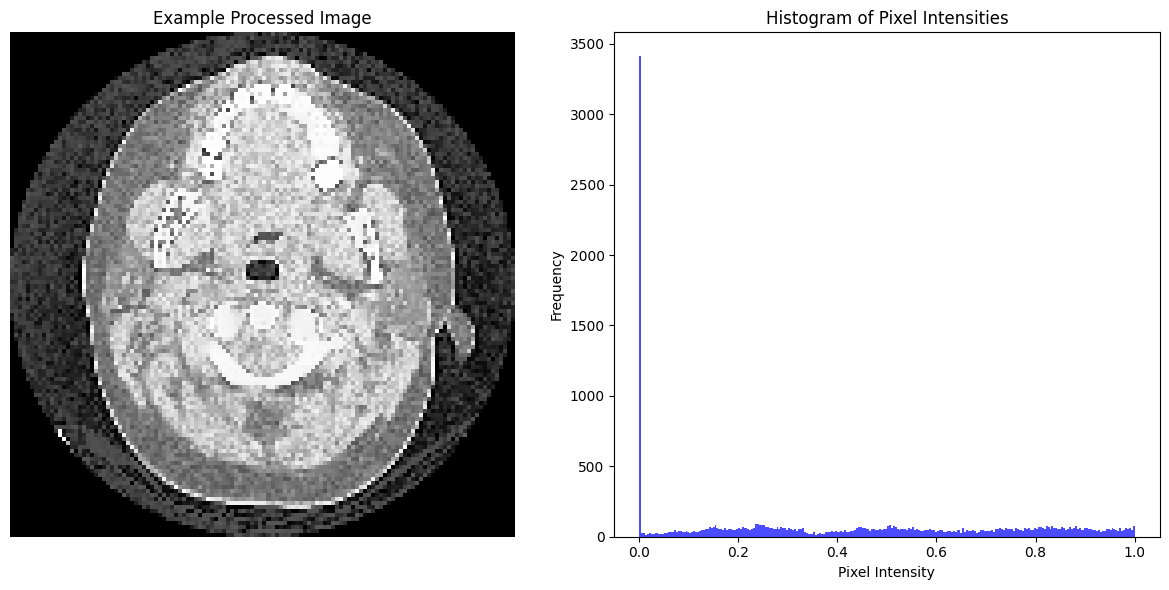

In [ ]:
example_image = processed_tumor_images_fail[0]

# Plot the example image and its histogram
plt.figure(figsize=(12, 6))

# Display the image
plt.subplot(1, 2, 1)
plt.title("Example Processed Image")
plt.imshow(example_image, cmap='gray')
plt.axis('off')

# Display the histogram
plt.subplot(1, 2, 2)
plt.title("Histogram of Pixel Intensities")
plt.hist(example_image.ravel(), bins=256, range=(0.0, 1.0), color='blue', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#Başarısız normalize adımın plot hali.


In [ ]:
# 1. Veriyi hazırlama
labels_tumor = np.zeros(len(normalize_and_resize_tumor))  # Tumor için etiket 0
labels_aneurysm = np.ones(len(normalize_and_resize_aneurysm))  # Aneurysm için etiket 1

images = np.concatenate([normalize_and_resize_tumor, normalize_and_resize_aneurysm], axis=0)
labels = np.concatenate([labels_tumor, labels_aneurysm], axis=0)

# One-hot encoding (Keras modelleri için gerekli)
labels = tf.keras.utils.to_categorical(labels, num_classes=2)

# Eğitim, doğrulama ve test veri setlerini bölme
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


#veri haline getirme işlemi
#metrisleri ve label sütunu elde edip bir dataframe haline getirdik. 

In [ ]:
print("X_train shape:", X_train.shape)  
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (106, 126, 126, 3)
X_val shape: (27, 126, 126, 3)
X_test shape: (34, 126, 126, 3)


In [ ]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=None  # enhance_image gibi özel bir fonksiyon varsa buraya ekleyin
)

train_generator = image_gen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_generator = image_gen.flow(X_val, y_val, batch_size=64, shuffle=False)
test_generator = image_gen.flow(X_test, y_test, batch_size=64, shuffle=False)
#Model Kurulumu

In [ ]:
# Katman sayısını artırılmış model
learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max', input_shape=(126, 126, 3))
x = base_model.output

# Ek katmanlar ekleme
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Çıkış katmanı
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Model derleme
optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(train_generator, epochs=5, validation_data=val_generator)
#Model kurulumu

Epoch 1/5
2/2 [==============================] - 12s 4s/step - loss: 1.0208 - accuracy: 0.5283 - val_loss: 0.6938 - val_accuracy: 0.4815
Epoch 2/5
2/2 [==============================] - 5s 2s/step - loss: 0.6443 - accuracy: 0.6604 - val_loss: 0.6939 - val_accuracy: 0.4815
Epoch 3/5
2/2 [==============================] - 6s 2s/step - loss: 0.5250 - accuracy: 0.7547 - val_loss: 0.6946 - val_accuracy: 0.4815
Epoch 4/5
2/2 [==============================] - 6s 4s/step - loss: 0.5567 - accuracy: 0.7736 - val_loss: 0.6961 - val_accuracy: 0.4815
Epoch 5/5
2/2 [==============================] - 6s 4s/step - loss: 0.4411 - accuracy: 0.8208 - val_loss: 0.7155 - val_accuracy: 0.4815


In [ ]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

#Evaluate işlemi yaptım


1/1 [==============================] - 0s 364ms/step - loss: 0.7088 - accuracy: 0.5000
Test Loss: 0.7087523341178894
Test Accuracy: 0.5


In [22]:

# Test verilerinin gerçek etiketlerini al
y_true = y_test.argmax(axis=1)  # Y_test zaten gerçek etiketlerdir (one-hot encoded ise argmax kullanılır).

# Model tahminlerini yap
y_pred_probs = model.predict(test_generator)  # Tahmin edilen olasılıklar
y_pred = y_pred_probs.argmax(axis=1)  # Tahmin edilen sınıflar

# F1-Score ve Recall hesaplama
f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted ortalama
recall = recall_score(y_true, y_pred, average='weighted')

# Sonuçları yazdır
print("Test F1-Score:", f1)
print("Test Recall:", recall)


1/1 [==============================] - 1s 795ms/step
Test F1-Score: 0.3333333333333333
Test Recall: 0.5


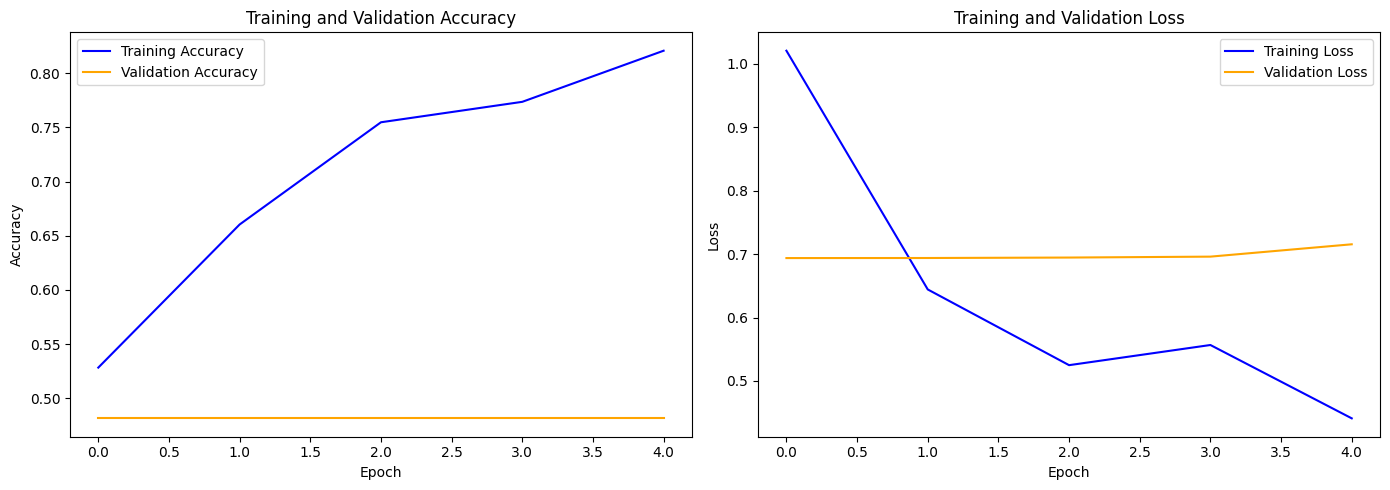

In [ ]:
# skorlar
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots: one for accuracy and one for loss
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

#Kaggle

#Burası da Yorum bölümü. Bu görseli direk yoruma eklersin

2/2 [==============================] - 1s 45ms/step


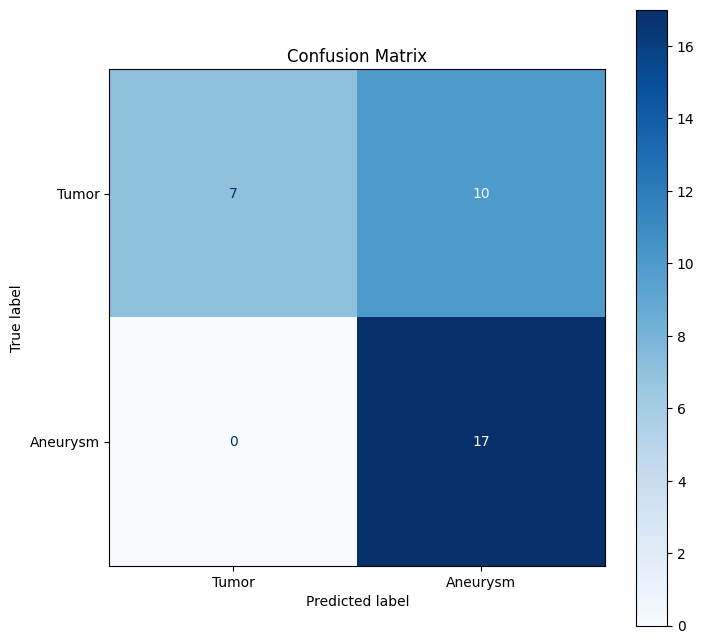

In [24]:


# Gerçek sınıf etiketlerini al
true_classes = np.argmax(y_test, axis=1)  # One-hot encoded olduğu için argmax ile alın

# Test seti için tahminler yap
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # En yüksek olasılıklı sınıfı seç

# Karışıklık matrisini hesapla
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Karışıklık matrisini görselleştir
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Tumor", "Aneurysm"]).plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

#Yorum bölümü, en önemli kısım burası burayı yoruma ekle.

